# COVID-19 Vaccination Project: Regression

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

## Importing cleaned dataset 

In [2]:
# importing dataset from prior notebook
# 'full' because it has all 17 features

vax_data_full = pd.read_csv('vax_data.csv')
vax_data_full.head()

,state,county,vote_split,%_unvax,%_diff,pop_density,household_size,%_uninsured,%_poverty_rate,%_age_65_plus,%_asian,%_black,%_hispanic,%_native,%_pac_isl,%_white,%_computer,%_phone,%_hs_grad,%_bachelors,median_house_income
0,Alabama,Autauga County,"(30, 100]",56.4,44.42,93.99,2.59,7.1,15.4,15.97,1.0,19.0,2.8,0.3,0.0,74.6,73.0,78.4,88.5,26.6,58731
1,Alabama,Baldwin County,"(30, 100]",48.1,53.76,140.41,2.61,10.2,10.6,20.98,0.9,9.3,4.6,0.8,0.0,83.1,76.3,81.7,90.8,31.9,58320
2,Alabama,Barbour County,"(-10, 10]",56.1,7.66,27.89,2.49,11.2,28.9,19.69,0.5,47.6,4.4,0.3,0.0,45.8,51.9,64.2,73.2,11.6,32525
3,Alabama,Bibb County,"(30, 100]",63.0,57.73,35.98,2.99,7.9,14.0,16.67,0.1,22.3,2.6,0.1,0.0,74.5,54.7,66.6,79.1,10.4,47542
4,Alabama,Blount County,"(30, 100]",68.5,80.00,89.68,2.77,11.0,14.4,18.70,0.4,1.6,9.3,0.1,0.0,86.9,63.5,70.1,80.5,13.1,49358


In [3]:
# total of 2533 counties, 17 features 

vax_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533 entries, 0 to 2532
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state                2533 non-null   object 
 1   county               2533 non-null   object 
 2   vote_split           2533 non-null   object 
 3   %_unvax              2533 non-null   float64
 4   %_diff               2533 non-null   float64
 5   pop_density          2533 non-null   float64
 6   household_size       2533 non-null   float64
 7   %_uninsured          2533 non-null   float64
 8   %_poverty_rate       2533 non-null   float64
 9   %_age_65_plus        2533 non-null   float64
 10  %_asian              2533 non-null   float64
 11  %_black              2533 non-null   float64
 12  %_hispanic           2533 non-null   float64
 13  %_native             2533 non-null   float64
 14  %_pac_isl            2533 non-null   float64
 15  %_white              2533 non-null   f

## Finding correlations among the data 

### Initial correlations (all 17 features)
> Hard to tell what's going on with so many features!

In [4]:
vax_data_full.corr()

,%_unvax,%_diff,pop_density,household_size,%_uninsured,%_poverty_rate,%_age_65_plus,%_asian,%_black,%_hispanic,%_native,%_pac_isl,%_white,%_computer,%_phone,%_hs_grad,%_bachelors,median_house_income
%_unvax,1.000000,0.407550,-0.101410,0.007633,0.309600,0.264884,0.046411,-0.308564,0.193690,-0.209827,-0.125311,-0.080801,0.025667,-0.394799,-0.286378,-0.368505,-0.417463,-0.365915
%_diff,0.407550,1.000000,-0.269274,-0.111649,0.075381,-0.075693,0.263132,-0.485334,-0.475088,-0.228719,-0.097206,-0.063064,0.606064,-0.261620,-0.305016,-0.146841,-0.552308,-0.285447
pop_density,-0.101410,-0.269274,1.000000,0.032227,-0.029717,-0.011741,-0.128506,0.370857,0.080813,0.182395,-0.027713,0.010749,-0.189569,0.123058,0.158706,0.009623,0.249457,0.171603
household_size,0.007633,-0.111649,0.032227,1.000000,0.386963,0.143360,-0.586297,0.196273,0.105921,0.432316,0.332578,0.092861,-0.436665,-0.000206,0.233865,-0.272518,0.011983,0.185211
%_uninsured,0.309600,0.075381,-0.029717,0.386963,1.000000,0.493544,-0.103223,-0.143417,0.277678,0.170043,0.422912,0.033802,-0.451172,-0.438361,-0.230084,-0.498214,-0.310905,-0.400979
%_poverty_rate,0.264884,-0.075693,-0.011741,0.143360,0.493544,1.000000,-0.107749,-0.174667,0.480658,-0.044052,0.273803,-0.045422,-0.450136,-0.700411,-0.482468,-0.662015,-0.447921,-0.746085
%_age_65_plus,0.046411,0.263132,-0.128506,-0.586297,-0.103223,-0.107749,1.000000,-0.304831,-0.182651,-0.279540,-0.122813,-0.100922,0.374309,-0.117182,-0.469144,0.098307,-0.212593,-0.253969
%_asian,-0.308564,-0.485334,0.370857,0.196273,-0.143417,-0.174667,-0.304831,1.000000,0.018727,0.358089,-0.058758,0.200642,-0.308851,0.419415,0.446274,0.161673,0.585285,0.528171
%_black,0.193690,-0.475088,0.080813,0.105921,0.277678,0.480658,-0.182651,0.018727,1.000000,-0.057134,-0.101722,-0.077869,-0.762320,-0.410644,-0.085182,-0.383530,-0.096133,-0.279664
%_hispanic,-0.209827,-0.228719,0.182395,0.432316,0.170043,-0.044052,-0.279540,0.358089,-0.057134,1.000000,0.002117,0.187774,-0.462314,0.181107,0.337153,-0.225121,0.138821,0.216964


In [5]:
# correlations with % unvaccinated

vax_data_full_corr = vax_data_full.corr()['%_unvax'].sort_values(ascending=False)
vax_data_full_corr

%_unvax                1.000000
%_diff                 0.407550
%_uninsured            0.309600
%_poverty_rate         0.264884
%_black                0.193690
%_age_65_plus          0.046411
%_white                0.025667
household_size         0.007633
%_pac_isl             -0.080801
pop_density           -0.101410
%_native              -0.125311
%_hispanic            -0.209827
%_phone               -0.286378
%_asian               -0.308564
median_house_income   -0.365915
%_hs_grad             -0.368505
%_computer            -0.394799
%_bachelors           -0.417463
Name: %_unvax, dtype: float64

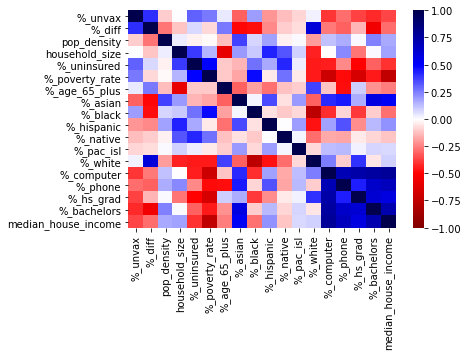

In [6]:
# %_diff is the most correlated, not surprisingly many features are strong correlated with each other

sns.heatmap(vax_data_full.corr(), cmap='seismic_r', vmin=-1, vmax=1);

### Determining variance inflation factor (VIF)

In [7]:
def vif(df_X):
    '''
    Returns the VIF for each feature of df_X (features in a df)
    '''
    vif_data = [variance_inflation_factor(df_X.values, i) # takes 2 arguments: x_values and their column index
                for i in range(df_X.shape[1])] ## returns num of columns
    return pd.Series(vif_data, index=df_X.columns)

In [8]:
# as expected, lot's of colinearity!

vif(vax_data_full.iloc[:, 4:]).sort_values()

pop_density              1.237269
%_pac_isl                1.281608
%_asian                  4.027458
%_diff                   7.158251
%_native                10.264759
%_uninsured             12.023488
%_hispanic              15.222989
%_bachelors             30.762243
%_poverty_rate          33.261784
%_age_65_plus           42.089817
%_black                 43.665609
median_house_income    100.417822
household_size         269.863745
%_phone                292.381953
%_computer             342.523776
%_white                792.437060
%_hs_grad              890.735526
dtype: float64

### Pruning features based on VIF 
>- Drop features with highest VIF: hs_grad, % white, %_computer, %_phone, household_size, median household income  
>- As a result we'll have 11 features going into modeling

In [9]:
vax_data = vax_data_full[['state', 'county', 'vote_split','%_unvax', '%_diff', '%_uninsured', '%_poverty_rate', 
                           '%_bachelors', 'pop_density', '%_age_65_plus',
                             '%_black','%_native', '%_hispanic', '%_asian',
                            '%_pac_isl']]
vax_data.head()

,state,county,vote_split,%_unvax,%_diff,%_uninsured,%_poverty_rate,%_bachelors,pop_density,%_age_65_plus,%_black,%_native,%_hispanic,%_asian,%_pac_isl
0,Alabama,Autauga County,"(30, 100]",56.4,44.42,7.1,15.4,26.6,93.99,15.97,19.0,0.3,2.8,1.0,0.0
1,Alabama,Baldwin County,"(30, 100]",48.1,53.76,10.2,10.6,31.9,140.41,20.98,9.3,0.8,4.6,0.9,0.0
2,Alabama,Barbour County,"(-10, 10]",56.1,7.66,11.2,28.9,11.6,27.89,19.69,47.6,0.3,4.4,0.5,0.0
3,Alabama,Bibb County,"(30, 100]",63.0,57.73,7.9,14.0,10.4,35.98,16.67,22.3,0.1,2.6,0.1,0.0
4,Alabama,Blount County,"(30, 100]",68.5,80.00,11.0,14.4,13.1,89.68,18.70,1.6,0.1,9.3,0.4,0.0


In [10]:
# wow, much less colinearity now!

vif(vax_data.iloc[:, 4:]).sort_values()

pop_density        1.214580
%_pac_isl          1.234175
%_native           1.837880
%_hispanic         2.129799
%_asian            2.582287
%_black            3.736611
%_diff             4.658899
%_bachelors        8.165424
%_poverty_rate    10.845430
%_uninsured       10.881047
%_age_65_plus     13.640261
dtype: float64

In [11]:
# delete used dataset

del vax_data_full

### Correlations on subset of data (11 features)

In [12]:
vax_data.corr()['%_unvax'].sort_values(ascending=False)

%_unvax           1.000000
%_diff            0.407550
%_uninsured       0.309600
%_poverty_rate    0.264884
%_black           0.193690
%_age_65_plus     0.046411
%_pac_isl        -0.080801
pop_density      -0.101410
%_native         -0.125311
%_hispanic       -0.209827
%_asian          -0.308564
%_bachelors      -0.417463
Name: %_unvax, dtype: float64

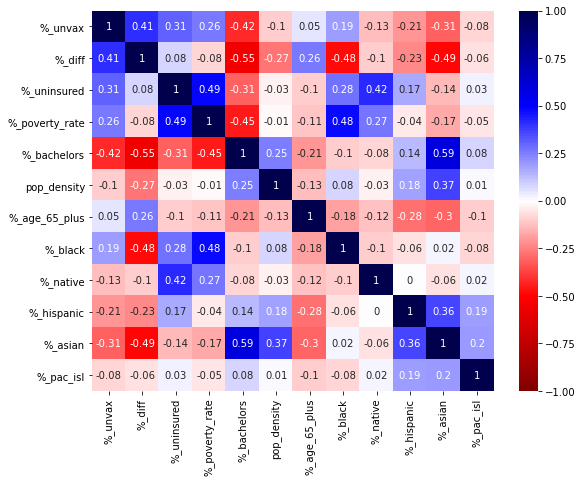

In [13]:
# heatmap still indicates strong correlations between some variables, but much better!

plt.figure(figsize=(9,7))
           
sns.heatmap(vax_data.corr().round(2), cmap='seismic_r', vmin=-1, vmax=1, annot=True);

## Baseline model

### Set-up modeling 

In [14]:
# separate features from our target

X = vax_data.iloc[:, 4:]
y = vax_data['%_unvax']

In [15]:
# create a hold out test set with 20% of data
# remaining 80% will be for validation/testing

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### Baseline model 

> Getting baseline model using vanilla linear regression (aka ordinary least squares [OLS]) and 5-fold cross validation

In [16]:
# lists for storing cross-validation mean and std_deviation R^2 scores
mean_scores = []
std_dev_scores =[]

def apply_5_fold_cv_to_training(model_, X, y):
    '''Applies 5-fold cross validation to a fitted model,
    returns mean R-squared scores
    '''
    
    kf = KFold(n_splits=5, shuffle=True, random_state=50)
    cv_scores = cross_val_score(model_, X, y, 
                cv=kf, 
                scoring='r2')
    
    mean_scores.append(cv_scores.mean())
    std_dev_scores.append(cv_scores.std())
    print(f'5-fold CV mean R^2 score: {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}')

In [17]:
# fit model
lm = LinearRegression()
lm.fit(X, y)

apply_5_fold_cv_to_training(model_=lm, X=X, y=y)

5-fold CV mean R^2 score: 0.3923 +/- 0.0589


## Expand and refine model

### Try adding interaction terms 

> Correlation matrix/heatmaps/pairplots indicate correlations between features, including:
>- %_asian and %_bachelors
>- % poverty and % black     

>- Adding interaction terms to our OLS model - unfortunately does not appear to significantly increase R-squared

In [18]:
# generating interaction terms

X2 = X.copy()

X2['asian_x_bachelors'] = X2['%_asian'] * X2['%_bachelors']
X2['poverty_x_black'] = X2['%_poverty_rate'] * X2['%_black']
X2.head()

,%_diff,%_uninsured,%_poverty_rate,%_bachelors,pop_density,%_age_65_plus,%_black,%_native,%_hispanic,%_asian,%_pac_isl,asian_x_bachelors,poverty_x_black
882,31.82,5.8,22.8,28.5,101.29,17.47,3.5,0.3,2.7,1.1,0.2,31.35,79.80
338,36.50,14.6,19.5,11.6,54.67,21.29,29.9,0.0,5.7,0.6,0.0,6.96,583.05
89,28.83,12.4,15.0,21.2,45.04,23.86,1.0,0.8,15.0,1.4,0.9,29.68,15.00
1168,45.57,10.1,15.6,14.2,42.77,22.09,0.5,0.3,3.7,0.3,0.0,4.26,7.80
895,51.22,5.2,30.3,9.7,32.08,20.35,3.6,0.1,0.5,0.0,0.0,0.00,109.08


In [19]:
lm = LinearRegression()
lm.fit(X2, y)

apply_5_fold_cv_to_training(model_=lm, X=X2, y=y)

5-fold CV mean R^2 score: 0.3999 +/- 0.0484


### Try adding polynomial terms
>- On pairplot, % black and % asian seem to have a slight curve  
>- So let's try adding polynomials to our OLS model - unfortunately does not appear to significantly increase R-squared

In [20]:
# generating polynomial terms

X2 = X.copy()

X2['black^2'] = X2['%_black'] ** 2
X2['asian^2'] = X2['%_asian'] ** 2
X2.head()

,%_diff,%_uninsured,%_poverty_rate,%_bachelors,pop_density,%_age_65_plus,%_black,%_native,%_hispanic,%_asian,%_pac_isl,black^2,asian^2
882,31.82,5.8,22.8,28.5,101.29,17.47,3.5,0.3,2.7,1.1,0.2,12.25,1.21
338,36.50,14.6,19.5,11.6,54.67,21.29,29.9,0.0,5.7,0.6,0.0,894.01,0.36
89,28.83,12.4,15.0,21.2,45.04,23.86,1.0,0.8,15.0,1.4,0.9,1.00,1.96
1168,45.57,10.1,15.6,14.2,42.77,22.09,0.5,0.3,3.7,0.3,0.0,0.25,0.09
895,51.22,5.2,30.3,9.7,32.08,20.35,3.6,0.1,0.5,0.0,0.0,12.96,0.00


In [21]:
lm = LinearRegression()
lm.fit(X2, y)

apply_5_fold_cv_to_training(model_=lm, X=X2, y=y)

5-fold CV mean R^2 score: 0.3980 +/- 0.0556


### Lasso
  
Let's try regularizing with lasso regression

#### Tune alpha with LassoCV

In [22]:
def apply_standard_scaler_to_training(X):
    '''Applies standard scaler to training data (fit and transform)
    '''
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values) 
    return X_scaled

In [23]:
X_scaled = apply_standard_scaler_to_training(X)

In [24]:
# run LassoCV - runs the cross validation, finds best alpha
# then re-fits model on best alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_scaled, y)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [25]:
# best alpha per LassoCV

lasso_model.alpha_

0.18464249428955434

#### Use Lasso with CV

In [26]:
X_scaled = apply_standard_scaler_to_training(X)

In [27]:
# second, fit a LASSO model on scaled data - using best alpha from LassoCV

lasso_model = Lasso(alpha = 0.18464249428955434)
lasso_model.fit(X_scaled, y)

apply_5_fold_cv_to_training(model_=lasso_model, X=X_scaled, y=y)

5-fold CV mean R^2 score: 0.3937 +/- 0.0573


In [28]:
# return coefficients
# Asian goes to zero

print('Feature coefficient results:\n')
for feature, coef in zip(X.columns, lasso_model.coef_):
    print(f'{feature}: {coef:.4f}')

Feature coefficient results:

%_diff: 7.8018
%_uninsured: 3.8491
%_poverty_rate: 1.0739
%_bachelors: -0.3207
pop_density: 0.2878
%_age_65_plus: -0.8738
%_black: 4.6458
%_native: -2.7419
%_hispanic: -2.1293
%_asian: -0.0000
%_pac_isl: -0.0798


### Ridge 

#### Tune alpha with Ridge CV

In [29]:
X_scaled = apply_standard_scaler_to_training(X)

In [30]:
# run RidgeCV - runs the cross validation, finds best alpha
# then re-fits model on best alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_scaled, y)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [31]:
# best alpha per RidgeCV

ridge_model.alpha_

47.68611697714469

### Use Ridge with CV 

In [32]:
X_scaled = apply_standard_scaler_to_training(X)

In [33]:
# second, fit a Ridge model on scaled data - using best alpha from RidgeCV

ridge_model = Ridge(alpha = 47.68611697714469)
ridge_model.fit(X_scaled, y)

apply_5_fold_cv_to_training(model_=lasso_model, X=X_scaled, y=y)

5-fold CV mean R^2 score: 0.3937 +/- 0.0573


In [34]:
# return coefficients
# not surprisingly, none of them went to zero

print('Feature coefficient results:\n')
for feature, coef in zip(X.columns, ridge_model.coef_):
    print(f'{feature}: {coef:.4f}')

Feature coefficient results:

%_diff: 7.4252
%_uninsured: 4.1291
%_poverty_rate: 1.1144
%_bachelors: -0.7582
pop_density: 0.4940
%_age_65_plus: -1.1698
%_black: 4.2609
%_native: -3.1259
%_hispanic: -2.4529
%_asian: 0.0822
%_pac_isl: -0.2599


## Plotting R-squared scores from 5-fold CV

In [35]:
# gathering mean and std deviation R^2 scores into a df

model_names = ['Ordinary least squares (OLS)', 'Interaction terms', 'Polynomial terms',
              'Lasso', 'Ridge']
scores = pd.DataFrame(model_names, columns=['model_names'])
scores['mean'] = mean_scores
scores['std_dev'] = std_dev_scores
scores = scores[::-1].reset_index(drop=True)
scores

,model_names,mean,std_dev
0,Ridge,0.393746,0.057343
1,Lasso,0.393746,0.057343
2,Polynomial terms,0.397973,0.055563
3,Interaction terms,0.399909,0.048449
4,Ordinary least squares (OLS),0.392279,0.058901


In [36]:
index = np.arange(5)
values = scores['mean']
std = scores['std_dev']
features = scores['model_names']

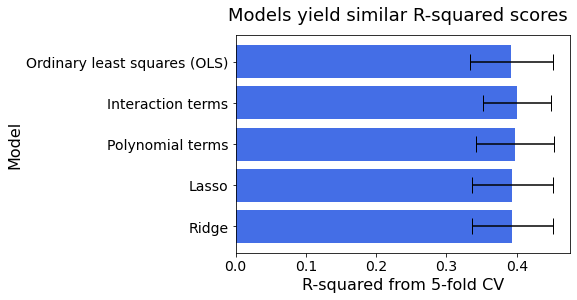

In [37]:
plt.barh(index, values, xerr=std, capsize=8, color='#446EE6')
plt.suptitle('Models yield similar R-squared scores', fontsize=18)
plt.xlabel('R-squared from 5-fold CV', fontsize=16)
plt.ylabel('Model', fontsize=16)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4],fontsize=14)
plt.yticks(index, features, fontsize=14);

## Final model 

Feature engineering or regularization did not improve metrics over the baseline (OLS), so we'll be going with OLS given it's iterpretability

But we'll scale the OLS model so that coefficients will be comparable

### Retrain best candidate on entire training set

In [38]:
# we will be training on all of X (only leaving out the 20% testing hold-out)
X.shape

(2026, 11)

In [39]:
# first, scale the training data - fit and transform in one

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

In [40]:
# then, apply OLS to the scaled data

lm_scaled = LinearRegression()
lm_scaled.fit(X_scaled, y)

# calculate R-squared on training set

y_pred_train = lm_scaled.predict(X_scaled)
r2_train = r2_score(y, y_pred_train)
print(f'R^2 on full training set: {r2_train}')

R^2 on full training set: 0.3999254667216162


In [41]:
# calculate MAE on training set

print(f'MAE is {np.mean(np.abs(y_pred_train - y))}')

MAE is 8.701371395125465


### Score best model on test set (hold-out)

In [42]:
# first scale test set

X_test_scaled = scaler.transform(X_test.values)

In [43]:
# calculate R-squared on testing set

y_test_pred = lm_scaled.predict(X_test_scaled)
r2_test = r2_score(y_test, y_test_pred)
print(f'R^2 on hold-out testing set: {r2_test}')

R^2 on hold-out testing set: 0.4253889760992424


In [44]:
# calculate MAE on testing set

print(f'MAE is {np.mean(np.abs(y_test_pred - y_test))}')

MAE is 8.136407257519416


## Boostrapping linear regression (OLS) coefficients 

In [45]:
def bootstrapped_regression_coefs(X, y, n_boot=100):
    '''Returns mean and 95% confidence intervals for boostrapped 
    linear regression coefficients'''
    
    coefs = []

    for n in range(n_boot): # loop over the number of bootstraps
        boot = np.random.randint(0, len(y), len(y)) # sample indices of data
        y_boot = y.iloc[boot] # use indexes to return values
        X_boot = X.iloc[boot]

        # scale features
        scalar = StandardScaler()
        X_boot_scaled = scalar.fit_transform(X_boot)

        # linear regression (OLS)
        model = LinearRegression()
        model.fit(X_boot_scaled, y_boot)

        coefs.append(model.coef_)
        
    mean = np.mean(np.array(coefs), axis = 0)
    lower = np.percentile(np.array(coefs), 2.5, axis=0)
    upper = np.percentile(np.array(coefs), 97.5, axis=0)
    return mean, lower, upper

In [46]:
# running boostrapped coeffients

mean_list, lower_list, upper_list = bootstrapped_regression_coefs(X, y)

In [47]:
# putting raw bootstrapped coefficient results into a DataFrame

boot_coef = pd.DataFrame(X.columns, columns=['features'])
boot_coef['mean'] = mean_list.reshape(-1,1) 
boot_coef['CI_lower'] = lower_list.reshape(-1,1) 
boot_coef['CI_upper'] = upper_list.reshape(-1,1)
boot_coef

,features,mean,CI_lower,CI_upper
0,%_diff,8.025612,6.934436,9.266972
1,%_uninsured,4.092592,2.973749,4.938731
2,%_poverty_rate,1.056915,0.207048,1.920703
3,%_bachelors,-0.481818,-1.584137,0.664672
4,pop_density,0.662031,0.124711,1.644164
5,%_age_65_plus,-1.113108,-1.803438,-0.392159
6,%_black,4.728497,3.477116,5.912668
7,%_native,-2.990629,-3.821257,-2.054327
8,%_hispanic,-2.425811,-3.177002,-1.869604
9,%_asian,0.058638,-0.890756,0.995732


### Plot bootstrapped coefficients 

In [48]:
# sorting in preparation for plotting

boot_coef = boot_coef.sort_values(by='mean')
boot_coef

,features,mean,CI_lower,CI_upper
7,%_native,-2.990629,-3.821257,-2.054327
8,%_hispanic,-2.425811,-3.177002,-1.869604
5,%_age_65_plus,-1.113108,-1.803438,-0.392159
3,%_bachelors,-0.481818,-1.584137,0.664672
10,%_pac_isl,-0.236496,-0.717236,0.192737
9,%_asian,0.058638,-0.890756,0.995732
4,pop_density,0.662031,0.124711,1.644164
2,%_poverty_rate,1.056915,0.207048,1.920703
1,%_uninsured,4.092592,2.973749,4.938731
6,%_black,4.728497,3.477116,5.912668


In [49]:
index = range(11)
values = boot_coef['mean']
lower = boot_coef['mean'] - boot_coef['CI_lower']
upper = boot_coef['CI_upper'] - boot_coef['mean']
features = ['% Native', '% Hispanic', '% Age 65+', '% Bachelors', \
            '% Pac Islander', '% Asian', 'Pop density', '% Poverty rate', \
            '% Uninsured', '% Black', '% 2020 Vote split']
colors = ['#446EE6' if x > 0 else '#E74444' for x in boot_coef['mean']]

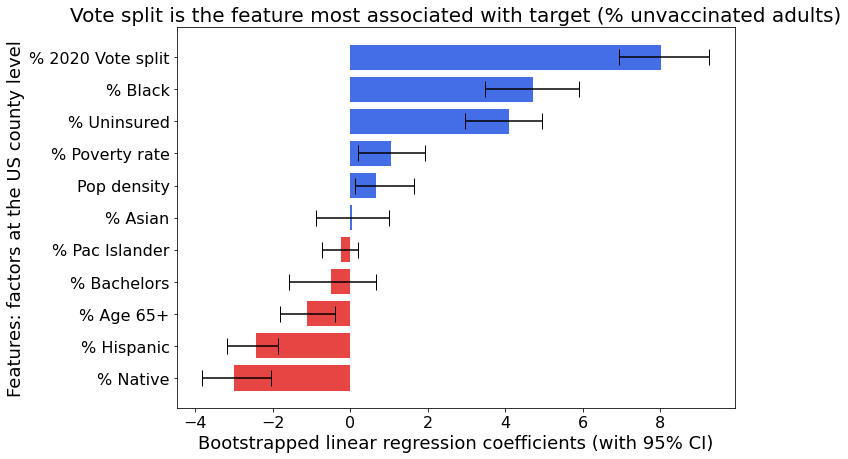

In [50]:
plt.figure(figsize = (10, 7))
plt.barh(index, values, xerr=(lower,upper), capsize=8, color=colors)
#plt.suptitle('Scaled OLS model: bootstrapped coefficients', fontsize=18)
plt.title('Vote split is the feature most associated with target (% unvaccinated adults)', fontsize=20)
plt.xlabel('Bootstrapped linear regression coefficients (with 95% CI)', fontsize=18)
plt.ylabel('Features: factors at the US county level', fontsize=18)
plt.yticks(index, features, fontsize=16)
plt.xticks(fontsize=16);

## Plotting each top feature individually

In [51]:
def prep_data_for_single_feature_plot(feature, target='%_unvax'):
    '''Prep data for plotting, including binning vote split
    '''
    
    X = vax_data[feature]
    y = vax_data[target]
    split = vax_data['vote_split']
    split_list = ['(-100, -30]', '(-30, -10]', '(-10, 10]', '(10, 30]', '(30, 100]']
    return X, y, split, split_list

In [52]:
def set_vote_split_legend():
    '''Set the legend and legend labels for vote split categories
    '''
    L = plt.legend()
    L.get_texts()[0].set_text('Biden 30+')
    L.get_texts()[1].set_text('Biden 10-30')
    L.get_texts()[2].set_text('Biden 10 to Trump 10')
    L.get_texts()[3].set_text('Trump 10-30')
    L.get_texts()[4].set_text('Trump 30+')

In [53]:
def fit_a_line_to_plot(X, y):
    '''Fits a line to a plot of a single feature vs target (% unvaccinated)
    '''
    
    X = pd.DataFrame(X)
    
    lm = LinearRegression()
    lm.fit(X, y)
    
    plt.plot(X, X*lm.coef_[0] + lm.intercept_, c='darkgrey', linewidth=3)

### Plotting % diff (aka vote split)

In [54]:
X, y, split, split_list = prep_data_for_single_feature_plot(feature='%_diff')

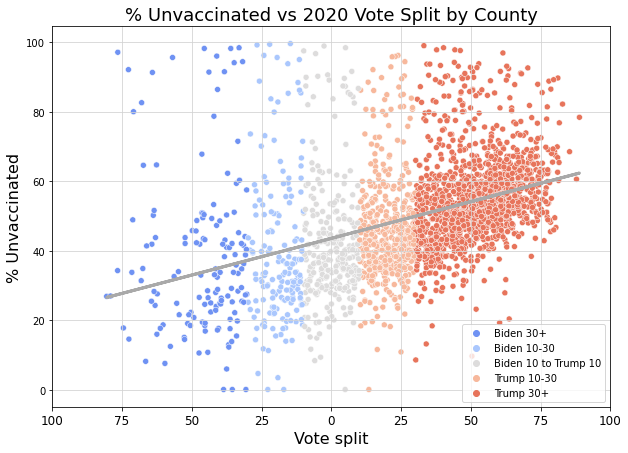

In [55]:
plt.figure(figsize=[10,7])

sns.scatterplot(x=X, y=y, hue=split, hue_order=split_list, palette='coolwarm')

plt.title('% Unvaccinated vs 2020 Vote Split by County', fontsize=18)
plt.ylabel('% Unvaccinated', fontsize=16)

plt.xlabel('Vote split', fontsize=16)
plt.xlim(-100, 100)
plt.xticks(range(-100, 120, 25), labels=[100, 75, 50, 25, 0, 25, 50, 75, 100], fontsize=12)
plt.grid(c='lightgrey')

set_vote_split_legend()

fit_a_line_to_plot(X, y);

### Plotting %black 

In [56]:
X, y, split, split_list = prep_data_for_single_feature_plot(feature='%_black')

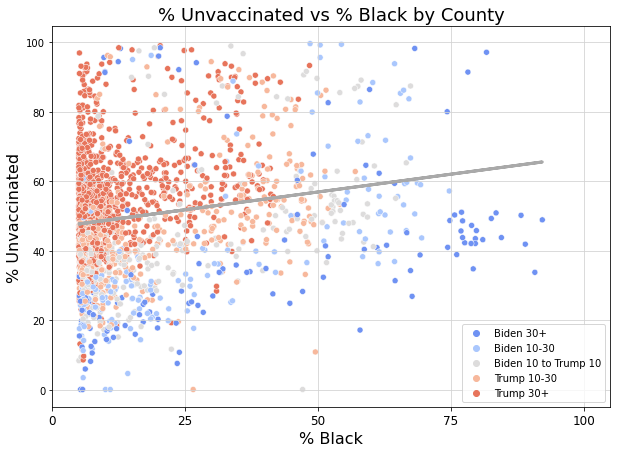

In [57]:
plt.figure(figsize=[10,7])

sns.scatterplot(x=X, y=y, hue=split, hue_order=split_list, palette='coolwarm', legend='full')

plt.title('% Unvaccinated vs % Black by County', fontsize=18)
plt.ylabel('% Unvaccinated', fontsize=16)

plt.xlabel('% Black', fontsize=16)  
plt.xlim(0, 100)
plt.xticks(range(-5, 120, 25), labels=[0, 25, 50, 75, 100], fontsize=12)
plt.grid(c='lightgrey')

set_vote_split_legend()

fit_a_line_to_plot(X, y);

### Plotting % uninsured 

In [58]:
X, y, split, split_list = prep_data_for_single_feature_plot(feature='%_uninsured')

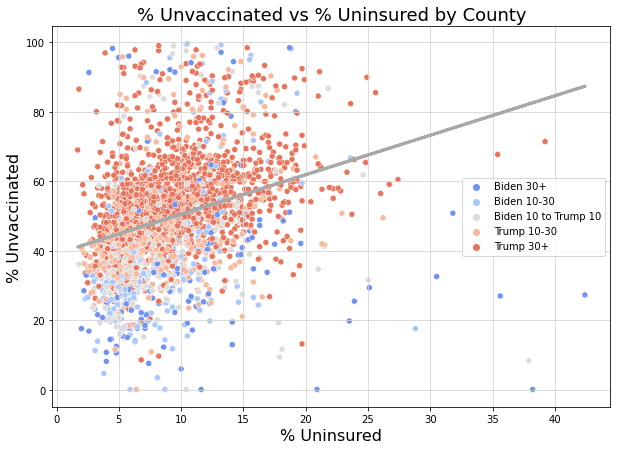

In [59]:
plt.figure(figsize=[10,7])

sns.scatterplot(x=X, y=y, hue=split, hue_order=split_list, palette='coolwarm', legend='full')

plt.title('% Unvaccinated vs % Uninsured by County', fontsize=18)
plt.ylabel('% Unvaccinated', fontsize=16)
plt.xlabel('% Uninsured', fontsize=16)
plt.grid(c='lightgrey')

set_vote_split_legend()

fit_a_line_to_plot(X, y);